In [1]:

from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

from ATARI.AutoFit import elim_addit_funcs


In [2]:
%matplotlib widget

In [83]:


sammypath = "/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy"

#%% 
# import bad cases

bad_case_dir = "/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/IFB_failed_cases/bad_cases_for_Noah_check"
bad_cases_ids = [190, 268, 105, 372, 127]
case_id = 372

case_filename = f'sample_{case_id}.pkl'
gen_params_filename =  f'params_gen.pkl'

# loading case
sample_data = elim_addit_funcs.load_obj_from_pkl(folder_name = bad_case_dir,
                                                     pkl_fname = case_filename )

params_loaded = elim_addit_funcs.load_obj_from_pkl(folder_name = bad_case_dir,
                                                     pkl_fname= gen_params_filename)

### define new particle pair for updated version
syndat_loaded = params_loaded
# Ta_pair_loaded = syndat_loaded.particle_pair
# Ta_pair = Ta_pair_loaded
Ta_pair = Particle_Pair()
Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=9.0030,
                       gn2_avg=452.56615,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D=8.3031,
                       gn2_avg=332.24347, 
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)


### udpate experiment template
for synmod in syndat_loaded.syndat_models:
    exp = synmod.generative_experimental_model
    filepath = os.path.realpath(f'./data/template_{exp.title}_edited')
    exp.template = os.path.realpath(filepath)


#%%
import plotting as myplot
from copy import deepcopy
from ATARI.AutoFit.initial_FB_solve import InitialFB, InitialFBOPT

sammy_rto_fit = sammy_classes.SammyRunTimeOptions(sammypath,
                                        {"Print":   True,
                                         "bayes":   True,
                                         "keep_runDIR": True,
                                         "sammy_runDIR": "sammy_runDIR"
                                         })


options = InitialFBOPT(Gn_threshold=1e-1,
                       iterations=2,
                       max_steps = 30,
                       LevMarV0=0.05,
                       fit_all_spin_groups=False,
                       spin_group_keys = ['3.0'],
                       step_threshold=0.01,
                       starting_Gn1_multiplier = 20,
                       num_Elam=50,
                       external_resonances=False)
autofit_initial = InitialFB(options)



datasets = [val.pw_reduced for key, val in sample_data.items()]
experiments = [synmod.generative_experimental_model for synmod in syndat_loaded.syndat_models]
covariance_data = [{} for key, val in sample_data.items()]


In [6]:

outs = autofit_initial.fit(Ta_pair,
                               [202, 227],
                               datasets,
                               experiments,
                               covariance_data,
                               sammy_rto_fit)


	FIT 1
Initial solve from 50 resonance features

Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.05 : [317719.0, 692025.0, 1032283.0, 8871.89, 14384.5, 2065283.39, 2435.4757]
1    0.075: [196119.0, 218095.0, 212778.0, 2765.97, 5068.33, 634826.3, 748.6159]
2    0.113: [8521.91, 5513.75, 13149.4, 1564.59, 3025.77, 31775.42, 37.471]
3    0.169: [943.599, 1845.41, 2144.24, 897.993, 1467.83, 7299.072, 8.6074]
4    0.253: [877.324, 1323.02, 1075.51, 588.776, 808.054, 4672.684, 5.5102]
5    0.38 : [905.339, 1256.84, 1046.37, 537.532, 684.029, 4430.11, 5.2242]
6    0.57 : [920.897, 1249.61, 1054.49, 532.522, 664.531, 4422.05, 5.2147]
Chi2 improvement below threshold

Complete after no neutron width features below threshold

	FIT 2
Initial solve from 50 resonance features

Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.05 : 

In [37]:
outs.sammy_outs_fit_2[-1].chi2_post

[775.38, 1117.24, 876.797, 247.01, 296.143]

Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.1  : [1917.58, 1462.38, 1004.82, 370.57, 585.142, 5340.492, 6.2977]
1    0.15 : [1450.2, 1142.86, 802.203, 380.318, 486.637, 4262.218, 5.0262]
2    0.225: [1252.49, 1116.86, 857.907, 471.487, 541.089, 4239.833, 4.9998]
3    0.338: [1071.97, 1091.63, 959.963, 524.42, 568.131, 4216.114, 4.9718]
4    0.506: [1041.98, 1087.33, 969.69, 531.898, 568.754, 4199.652, 4.9524]
Maximum steps reached


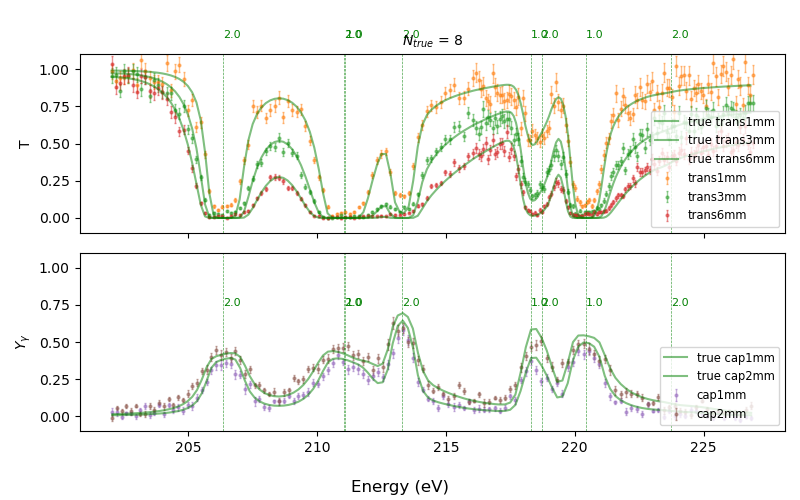

In [85]:

true_par = deepcopy(sample_data['trans1mm'].par_true)
true_par['varyE'] = np.ones(len(true_par))
true_par['varyGg'] = np.ones(len(true_par))
true_par['varyGn1'] = np.ones(len(true_par))

sammyINPyw = sammy_classes.SammyInputDataYW(
        particle_pair = Ta_pair,
        resonance_ladder = true_par,  

        datasets= datasets,
        experiments = experiments,
        experimental_covariance= covariance_data, 
        
        max_steps = 5,
        iterations = 2,
        step_threshold = 0.001,
        LevMar = True,
        LevMarV = 1.5,
        LevMarVd = 5,
        minF = 1e-5,
        maxF = 2.0,
        initial_parameter_uncertainty = 0.1,
        
        autoelim_threshold = None,
        LS = False,
        )

true_out = sammy_functions.run_sammy_YW(sammyINPyw, sammy_rto_fit)

# figure()
# _ = hist(np.log10(ending_parameters.Gn1), bins=50)

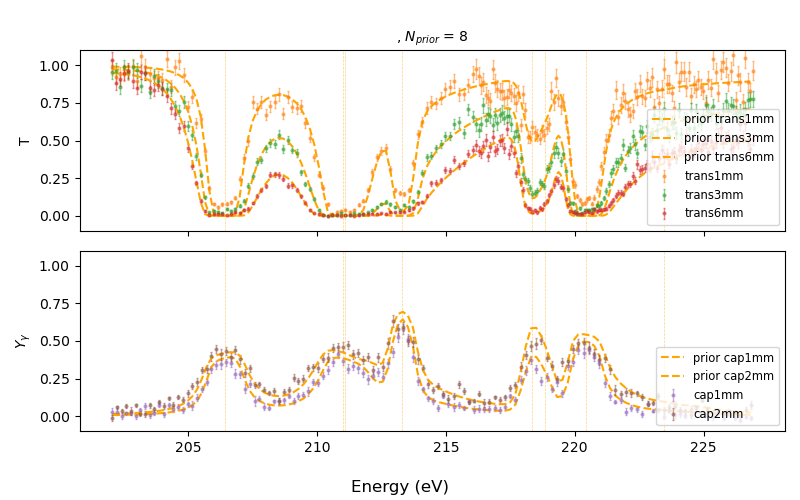

In [89]:


fig = myplot.plot_datafits(datasets,
                     experiments,
                #      fits = outs.sammy_outs_fit_2[-1].pw_post,
                #      fit_pars = outs.sammy_outs_fit_2[-1].par_post,
                     fig_size=(8,5),
                    #  true= true_out.pw_post,
                    #  true_pars = true_out.par_post,
                     priors=true_out.pw,
                     prior_pars=true_out.par
                     )
fig.tight_layout()

In [ ]:
np.tile([1,0], np.ceil(50/3))

In [73]:
vary1 = np.tile([0,1], 25)
vary2 = np.tile([1,0], 25)
chi2_per_ndat = np.sum(outs.sammy_outs_fit_2[-1].chi2_post) / np.sum([len(each) for each in outs.sammy_outs_fit_2[-1].pw_post])
parameters = deepcopy(outs.sammy_outs_fit_2[-1].par_post)
tracker = 1
while chi2_per_ndat > 1.0:

    if tracker % 2 == 0:
        parameters['varyE'] = vary1
        parameters['varyGg'] = vary1
        parameters['varyGn1'] = vary1
        print("vary1")
    else:
        parameters['varyE'] = vary2
        parameters['varyGg'] = vary2
        parameters['varyGn1'] = vary2
        print("vary2")

    sammyINPyw.resonance_ladder = parameters
    sammyout = sammy_functions.run_sammy_YW(sammyINPyw, sammy_rto_fit)
    chi2_per_ndat = np.sum(sammyout.chi2)/np.sum([len(each) for each in sammyout.pw_post])
    parameters = sammyout.par_post

    tracker += 1




vary2
Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.1  : [775.571, 1117.72, 875.882, 234.787, 266.109, 3270.069, 3.8562]
1    0.15 : [775.113, 1108.96, 858.611, 230.771, 269.157, 3242.612, 3.8238]
2    0.225: [775.405, 1108.77, 859.289, 229.328, 268.886, 3241.678, 3.8227]
3    0.338: [771.74, 1109.72, 860.863, 227.615, 269.715, 3239.653, 3.8203]
4    0.506: [768.249, 1110.62, 861.04, 227.052, 271.331, 3238.292, 3.8187]
Maximum steps reached
vary1
Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.1  : [768.31, 1110.58, 861.106, 230.359, 282.445, 3252.8, 3.8358]
1    0.15 : [768.129, 1113.41, 863.152, 227.564, 274.117, 3246.372, 3.8283]
2    0.225: [772.662, 1108.72, 864.094, 225.581, 274.319, 3245.376, 3.8271]
3    0.338: [772.913, 1108.35, 863.879, 224.864, 274.292, 3244.298, 3.8258]
4    0.506: [771.481, 1108.9, 863

KeyboardInterrupt: 

In [40]:
parameters_1 = deepcopy(sammyout.par_post)

vary = np.tile([1,0], int(len(parameters_1)/2))
parameters_1['varyE'] = vary
parameters_1['varyGg'] = vary
parameters_1['varyGn1'] = vary

sammyINPyw.resonance_ladder = parameters_1
sammyout = sammy_functions.run_sammy_YW(sammyINPyw, sammy_rto_fit)

Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.1  : [779.012, 1113.58, 877.888, 231.51, 274.052, 3276.042, 3.8633]
1    0.15 : [776.605, 1104.51, 862.078, 228.763, 277.232, 3249.188, 3.8316]
2    0.225: [774.758, 1102.85, 859.213, 227.627, 278.905, 3243.353, 3.8247]
Maximum steps reached


In [41]:
parameters_2 = deepcopy(sammyout.par_post)

vary = np.tile([0,1], int(len(parameters_2)/2))
parameters_2['varyE'] = vary
parameters_2['varyGg'] = vary
parameters_2['varyGn1'] = vary
sammyINPyw.resonance_ladder = parameters_2
sammyout = sammy_functions.run_sammy_YW(sammyINPyw, sammy_rto_fit)


Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.1  : [774.756, 1102.86, 859.208, 227.627, 278.905, 3243.356, 3.8247]
1    0.15 : [776.592, 1105.11, 859.696, 226.06, 272.243, 3239.701, 3.8204]
2    0.225: [775.956, 1107.06, 860.885, 225.006, 270.631, 3239.538, 3.8202]
Chi2 improvement below threshold


In [42]:

parameters_3 = deepcopy(sammyout.par_post)
vary = np.tile([1,0], int(len(parameters_3)/2))
parameters_3['varyE'] = vary
parameters_3['varyGg'] = vary
parameters_3['varyGn1'] = vary
sammyINPyw.resonance_ladder = parameters_3
sammyout = sammy_functions.run_sammy_YW(sammyINPyw, sammy_rto_fit)



Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.1  : [775.953, 1107.07, 860.886, 225.007, 270.63, 3239.546, 3.8202]
1    0.15 : [770.907, 1105.59, 860.386, 224.34, 270.543, 3231.766, 3.811]
2    0.225: [768.552, 1107.01, 860.376, 223.804, 270.768, 3230.51, 3.8096]
Maximum steps reached


In [43]:

parameters_4 = deepcopy(sammyout.par_post)
vary = np.tile([0,1], int(len(parameters_4)/2))
parameters_4['varyE'] = vary
parameters_4['varyGg'] = vary
parameters_4['varyGn1'] = vary
sammyINPyw.resonance_ladder = parameters_4
sammyout = sammy_functions.run_sammy_YW(sammyINPyw, sammy_rto_fit)

Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.1  : [768.547, 1107.02, 860.38, 223.805, 270.767, 3230.519, 3.8096]
1    0.15 : [771.331, 1106.93, 858.378, 223.991, 267.233, 3227.863, 3.8064]
2    0.225: [770.987, 1107.89, 858.177, 223.507, 266.468, 3227.029, 3.8055]
Chi2 improvement below threshold


In [44]:
parameters_5 = deepcopy(sammyout.par_post)
vary = np.tile([1,0], int(len(parameters_5)/2))
parameters_5['varyE'] = vary
parameters_5['varyGg'] = vary
parameters_5['varyGn1'] = vary
sammyINPyw.resonance_ladder = parameters_5
sammyout = sammy_functions.run_sammy_YW(sammyINPyw, sammy_rto_fit)

Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.1  : [770.996, 1107.89, 858.173, 223.507, 266.471, 3227.037, 3.8055]
1    0.15 : [767.868, 1105.56, 857.151, 223.402, 266.712, 3220.693, 3.798]
2    0.225: [767.887, 1105.3, 857.57, 223.386, 266.237, 3220.38, 3.7976]
Chi2 improvement below threshold


In [45]:
parameters_6 = deepcopy(sammyout.par_post)
vary = np.tile([0,1], int(len(parameters_6)/2))
parameters_6['varyE'] = vary
parameters_6['varyGg'] = vary
parameters_6['varyGn1'] = vary
sammyINPyw.resonance_ladder = parameters_6
sammyout = sammy_functions.run_sammy_YW(sammyINPyw, sammy_rto_fit)

Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.1  : [767.882, 1105.3, 857.573, 223.386, 266.237, 3220.378, 3.7976]
1    0.15 : [768.764, 1106.99, 856.587, 222.02, 263.369, 3217.73, 3.7945]
2    0.225: [769.283, 1107.45, 856.869, 221.785, 261.988, 3217.375, 3.7941]
Chi2 improvement below threshold


In [46]:
parameters_7 = deepcopy(sammyout.par_post)
vary = np.tile([1,0], int(len(parameters_7)/2))
parameters_7['varyE'] = vary
parameters_7['varyGg'] = vary
parameters_7['varyGn1'] = vary
sammyINPyw.resonance_ladder = parameters_7
sammyout = sammy_functions.run_sammy_YW(sammyINPyw, sammy_rto_fit)

Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.1  : [769.275, 1107.46, 856.873, 221.784, 261.988, 3217.38, 3.7941]
1    0.15 : [766.753, 1105.15, 855.702, 221.805, 262.222, 3211.632, 3.7873]
2    0.225: [766.256, 1105.18, 856.022, 221.766, 261.95, 3211.174, 3.7868]
Chi2 improvement below threshold


In [47]:
parameters_8 = deepcopy(sammyout.par_post)
vary = np.tile([0,1], int(len(parameters_8)/2))
parameters_8['varyE'] = vary
parameters_8['varyGg'] = vary
parameters_8['varyGn1'] = vary
sammyINPyw.resonance_ladder = parameters_8
sammyout = sammy_functions.run_sammy_YW(sammyINPyw, sammy_rto_fit)

Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.1  : [766.254, 1105.18, 856.027, 221.768, 261.95, 3211.179, 3.7868]
1    0.15 : [767.692, 1106.77, 855.138, 220.748, 259.376, 3209.724, 3.7851]
2    0.225: [768.175, 1107.06, 854.983, 220.51, 258.455, 3209.183, 3.7844]
Chi2 improvement below threshold


In [48]:
parameters_9 = deepcopy(sammyout.par_post)
vary = np.tile([1,0], int(len(parameters_9)/2))
parameters_9['varyE'] = vary
parameters_9['varyGg'] = vary
parameters_9['varyGn1'] = vary
sammyINPyw.resonance_ladder = parameters_9
sammyout = sammy_functions.run_sammy_YW(sammyINPyw, sammy_rto_fit)

Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.1  : [768.176, 1107.06, 854.98, 220.51, 258.457, 3209.183, 3.7844]
1    0.15 : [766.451, 1104.24, 854.97, 220.914, 258.374, 3204.949, 3.7794]
2    0.225: [765.161, 1105.07, 855.141, 220.423, 258.745, 3204.54, 3.7789]
Chi2 improvement below threshold


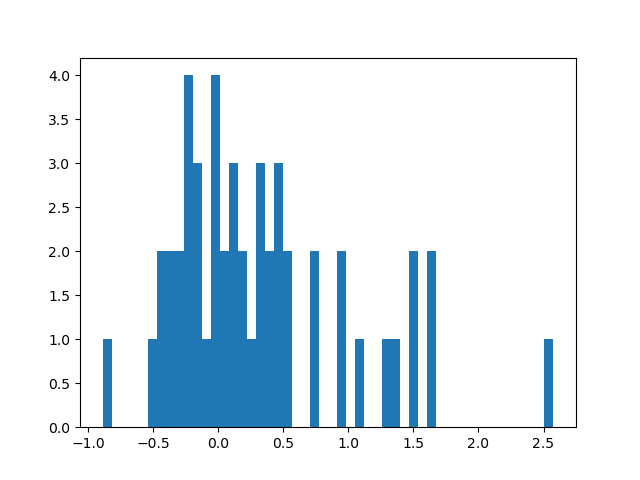

In [53]:
figure()
_ = hist(np.log10(sammyout.par_post.Gn1), bins=50)

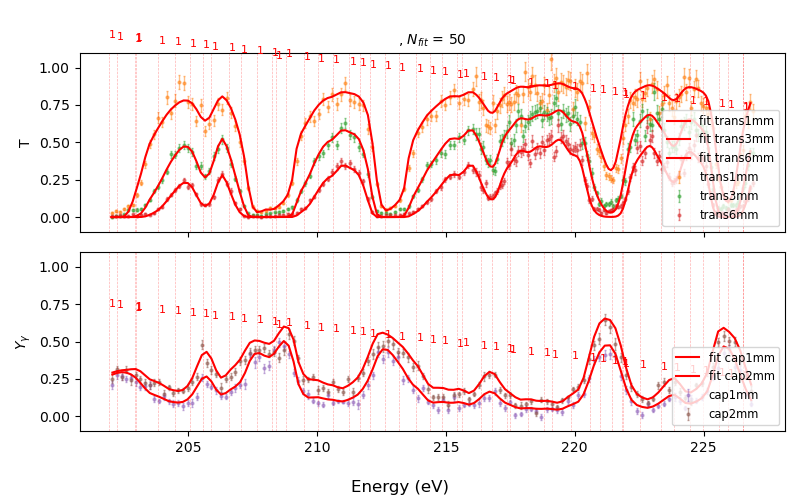

In [54]:

fig = myplot.plot_datafits(datasets,
                     experiments,
                     fits = sammyout.pw_post,
                     fit_pars = sammyout.par_post,
                     fig_size=(8,5))
fig.tight_layout()